In [ ]:
!pip install langchain
!pip install openai

In [ ]:
!!pip install llama-index
!pip install html2text

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "..."

In [ ]:
import os
os.environ["GOOGLE_CSE_ID"] = "「検索エンジンID」"
os.environ["GOOGLE_API_KEY"] = "「API KEY」"

In [ ]:
import sqlite3

# データベース接続を作成する
conn = sqlite3.connect('user_support.db')

# カーソルオブジェクトを作成する
cursor = conn.cursor()

# usersテーブルを作成する
cursor.execute('''
CREATE TABLE users (
    user_id INTEGER PRIMARY KEY,
    first_name TEXT,
    last_name TEXT,
    email TEXT,
    phone TEXT
)
''')

# productsテーブルを作成する
cursor.execute('''
CREATE TABLE products (
    product_id INTEGER PRIMARY KEY,
    product_name TEXT,
    price INTEGER
)
''')

# order_historyテーブルを作成する
cursor.execute('''
CREATE TABLE order_history (
    history_id INTEGER PRIMARY KEY,
    user_id INTEGER,
    product_id INTEGER,
    purchase_date DATE,
    quantity INTEGER,
    remarks TEXT,
    created_at DATETIME,
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id)
)
''')

# support_historyテーブルを作成する
cursor.execute('''
CREATE TABLE support_history (
    history_id INTEGER PRIMARY KEY,
    user_id INTEGER,
    subject TEXT,
    message_content TEXT,
    message_type TEXT,
    status TEXT,
    created_at DATETIME,
    FOREIGN KEY (user_id) REFERENCES users(user_id)
)
''')

# 変更をコミットする
conn.commit()

# データベース接続を閉じる
conn.close()

In [ ]:
import sqlite3
from datetime import datetime

# データベース接続を作成する
conn = sqlite3.connect('user_support.db')

# カーソルオブジェクトを作成する
cursor = conn.cursor()

# usersテーブルに日本語のテストデータを挿入する
users_data = [
    (1, '太郎', '山田', 'taro@example.com', '090-1234-5678'),
    (2, '花子', '佐藤', 'hanako@example.com', '080-9876-5432')
]

for user in users_data:
    cursor.execute('''
    INSERT INTO users (user_id, first_name, last_name, email, phone)
    VALUES (?, ?, ?, ?, ?)
    ''', user)

# productsテーブルに日本語のテストデータを挿入する
products_data = [
    (1, '商品A', 1000),
    (2, '商品B', 2000),
    (3, '商品C', 3000)
]

for product in products_data:
    cursor.execute('''
    INSERT INTO products (product_id, product_name, price)
    VALUES (?, ?, ?)
    ''', product)

# order_historyテーブルに日本語のテストデータを挿入する
order_history_data = [
    (1, 1, 1, '2023-04-01', 2, '迅速な発送', datetime.now()),
    (2, 2, 3, '2023-04-05', 1, 'ギフトラッピング', datetime.now())
]

for order in order_history_data:
    cursor.execute('''
    INSERT INTO order_history (history_id, user_id, product_id, purchase_date, quantity, remarks, created_at)
    VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', order)

# support_historyテーブルに日本語のテストデータを挿入する
support_history_data = [
    (1, 1, '請求に関する問題', None, None, 'open', datetime.now()),
    (2, 1, None, '請求に問題があります。', 'user', None, datetime.now()),
    (3, 1, None, 'お問い合わせいただきありがとうございます。問題を調査しています。', 'support', None, datetime.now())
]

for support in support_history_data:
    cursor.execute('''
    INSERT INTO support_history (history_id, user_id, subject, message_content, message_type, status, created_at)
    VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', support)

# 変更をコミットする
conn.commit()

# データベース接続を閉じる
conn.close()

差し替え分

In [ ]:
from langchain import OpenAI
from langchain.chat_models import ChatOpenAI
from llama_index import GPTVectorStoreIndex
from llama_index import SimpleWebPageReader
from langchain.agents import initialize_agent, Tool
from langchain.chains import LLMChain
from langchain import LLMMathChain
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from llama_index import download_loader
from langchain.utilities import GoogleSearchAPIWrapper
from langchain.utilities import PythonREPL
from langchain.prompts import PromptTemplate
from langchain import SQLDatabase
from langchain import SQLDatabaseChain

llm = ChatOpenAI(
    temperature=0,
)

#---------- For Database tool ------------------------
sql_uri = "sqlite:///user_support.db"
db= SQLDatabase.from_uri(sql_uri)
template="""Given an input question, first refer table_info and create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Use the following format:

Question: "Question here"
SQLQuery: "SQL Query to run"
SQLResult: "Result of the SQLQuery"
Answer: "Final answer here. in japanese"

Only use the following tables:

{table_info}

If someone asks for ユーザ,顧客,customers, they really mean the users table.
If someone asks for 購買履歴, they really mean the order_history table.
If someone asks for 対応履歴, they really mean the support_history table.

Question: {input}"""

prompt = PromptTemplate(input_variables=["input","table_info", "dialect"],template=template)
db_chain = SQLDatabaseChain.from_llm(llm,db,prompt=prompt,verbose=True)

#--------- For Google search tool ----------
search = GoogleSearchAPIWrapper()

#汎用的で普通の会話をするために単一のChainを作ってツールとして登録する
prompt = PromptTemplate(input_variables=["query"],template="{query}この要求文をできる限り日本語で回答してください。")
chain_general = LLMChain(llm=ChatOpenAI(temperature=0.5),prompt=prompt)

#---------- 計算するためのChain ------------
llm_math_chain = LLMMathChain.from_llm(llm=llm, verbose=True)

#---------- Python Tool ------------
python_repl = PythonREPL()

#----------- 無常をよしなに答えてくれるためのChain -------------
BeautifulSoupWebReader = download_loader("BeautifulSoupWebReader")
loader = BeautifulSoupWebReader()
documents = loader.load_data(urls=['https://www.aozora.gr.jp/cards/000196/files/60669_74788.html'])
index_chomei = GPTVectorStoreIndex.from_documents(documents=documents)


#----------- Agent ツール ---------
tools =[
        Tool(
          name="SQL Database",
          func=db_chain.run,
          description="顧客に関することをデータベースに問い合わせに答えるときに便利です。",
          #return_direct=True
        ),
        Tool(
          name = "Google Search",
          func=search.run,
          description="最新情報を調べる場合に便利です。",
          #return_direct=True
        ),
        Tool(
          name="Calculator",
          func=llm_math_chain.run,
          description="計算をする場合に便利です。"
        ),
        Tool(
          name="python_repl",
          description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
          func=python_repl.run
        ),
        Tool(
          name="chomei",
          func=lambda q: str(index_chomei.as_query_engine().query(q)),
          description="無常について考えるとき、方丈記についての質問に答えるときに便利です。",
        ),
        Tool(
          name="general",
          func=chain_general.run,
          description="雑談や汎用的な要求文に答えるときに便利です。",
          return_direct=True,
        ),
      ]
#------------ ChatボットAgent 初期化----------
llm = ChatOpenAI(
    temperature=0.5,
)
agent_kwargs = {
"suffix": """開始!ここからの会話は全て日本語で行われます。

以前のチャット履歴
{chat_history}

新しいインプット: {input}
{agent_scratchpad}""",
}
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    agent_kwargs=agent_kwargs,
    verbose=True,
    memory=memory)

In [ ]:
agent.run("山田太郎さんの情報を表示してください")



> Entering new AgentExecutor chain...
{
    "action": "SQL Database",
    "action_input": "SELECT * FROM customers WHERE name='山田太郎'"
}

> Entering new SQLDatabaseChain chain...
SELECT * FROM customers WHERE name='山田太郎'
SQLQuery:SELECT * FROM users WHERE first_name='太郎' AND last_name='山田'
SQLResult: [(1, '太郎', '山田', 'taro@example.com', '090-1234-5678')]
Answer:ユーザID 1の太郎山田さんです。
> Finished chain.

Observation: ユーザID 1の太郎山田さんです。
Thought:{
    "action": "Final Answer",
    "action_input": "ユーザID 1の太郎山田さんです。"
}

> Finished chain.


'ユーザID 1の太郎山田さんです。'

In [ ]:
agent.run("DBを参照し購買履歴から商品別の売上を取得してください。")



> Entering new AgentExecutor chain...
{
    "action": "SQL Database",
    "action_input": "SELECT 商品名, SUM(価格) AS 売上 FROM 購買履歴 GROUP BY 商品名;"
}

> Entering new SQLDatabaseChain chain...
SELECT 商品名, SUM(価格) AS 売上 FROM 購買履歴 GROUP BY 商品名;
SQLQuery:SELECT product_name, SUM(price) AS sales FROM order_history JOIN products ON order_history.product_id = products.product_id GROUP BY product_name;
SQLResult: [('商品A', 1000), ('商品C', 3000)]
Answer:商品Aと商品Cの売上はそれぞれ1000円と3000円です。
> Finished chain.

Observation: 商品Aと商品Cの売上はそれぞれ1000円と3000円です。
Thought:{
    "action": "Final Answer",
    "action_input": "商品Aと商品Cの売上はそれぞれ1000円と3000円です。"
}

> Finished chain.


'商品Aと商品Cの売上はそれぞれ1000円と3000円です。'



> Entering new AgentExecutor chain...
```json
{
    "action": "python_repl",
    "action_input": "import matplotlib.pyplot as plt\n\n# 商品別の売上データ\nsales_data = {\n    'Product A': 1000,\n    'Product C': 3000\n}\n\n# グラフを作成\nplt.bar(sales_data.keys(), sales_data.values())\nplt.title('Sales by Product')\nplt.xlabel('Product')\nplt.ylabel('Sales (JPY)')\nplt.show()"
}
``` 

上記のコードを実行すると、商品別の売上データを元にmatplotlibを使ってグラフを作成することができます。グラフは横軸に商品名、縦軸に売上をとり、各商品の売上を棒グラフで表示しています。

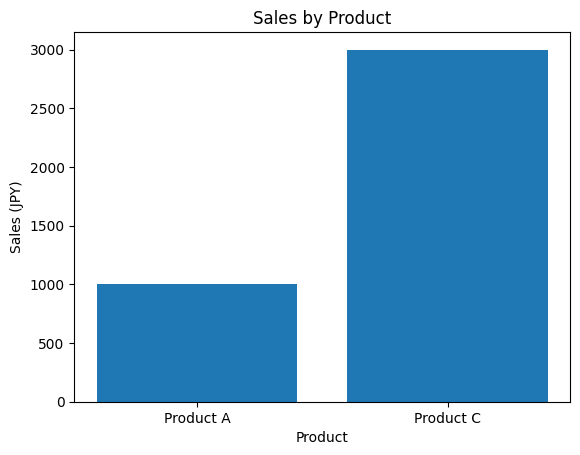


Observation: 
Thought:

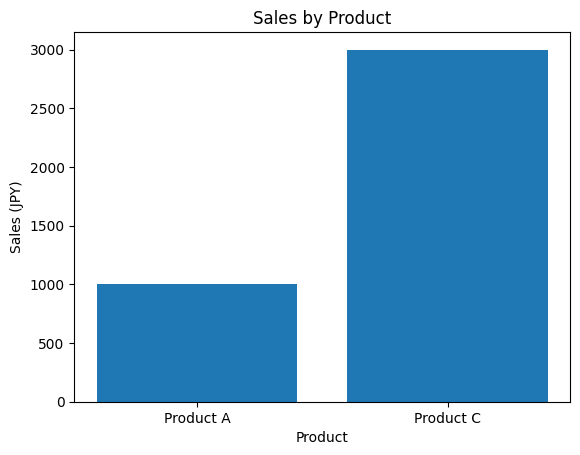

```json
{
    "action": "python_repl",
    "action_input": "import matplotlib.pyplot as plt\n\n# 商品別の売上データ\nsales_data = {\n    'Product A': 1000,\n    'Product C': 3000\n}\n\n# グラフを作成\nplt.bar(sales_data.keys(), sales_data.values())\nplt.title('Sales by Product')\nplt.xlabel('Product')\nplt.ylabel('Sales (JPY)')\nplt.show()"
}
```

上記のコードを実行すると、商品別の売上データを元にmatplotlibを使ってグラフを作成することができます。グラフは横軸に商品名、縦軸に売上をとり、各商品の売上を棒グラフで表示しています。
Observation: 
Thought:```json
{
    "action": "Final Answer",
    "action_input": "上記のコードを実行すると、商品別の売上データを元にmatplotlibを使ってグラフを作成することができます。グラフは横軸に商品名、縦軸に売上をとり、各商品の売上を棒グラフで表示しています。"
}
```

> Finished chain.


'上記のコードを実行すると、商品別の売上データを元にmatplotlibを使ってグラフを作成することができます。グラフは横軸に商品名、縦軸に売上をとり、各商品の売上を棒グラフで表示しています。'

In [ ]:
agent.run("商品別の売上をpythonでmatplotlibを使ってグラフにしてください。なお売上のあった商品だけでよく、ラベルは文字化け回避のため英語でよいです。")

In [ ]:
agent.run("さすがです。ところで、今日はいい天気です。")



> Entering new AgentExecutor chain...
```json
{
    "action": "general",
    "action_input": "今日は本当にいい天気ですね！お散歩に行くには最適ですね。"
}
```
Observation: はい、本当にいい天気ですね！お散歩に行くには最適ですね。


> Finished chain.


'はい、本当にいい天気ですね！お散歩に行くには最適ですね。'

In [ ]:
agent.run("山田太郎さん（ユーザID=1）に関する対応履歴を出力してください。")



> Entering new AgentExecutor chain...
```json
{
    "action": "SQL Database",
    "action_input": "SELECT * FROM 対応履歴 WHERE ユーザID = 1"
}
```

> Entering new SQLDatabaseChain chain...
SELECT * FROM 対応履歴 WHERE ユーザID = 1
SQLQuery:SELECT * FROM support_history WHERE user_id = 1
SQLResult: [(1, 1, '請求に関する問題', None, None, 'open', '2023-06-11 04:21:48.293863'), (2, 1, None, '請求に問題があります。', 'user', None, '2023-06-11 04:21:48.293865'), (3, 1, None, 'お問い合わせいただきありがとうございます。問題を調査しています。', 'support', None, '2023-06-11 04:21:48.293865')]
> Finished chain.

Observation: [(1, 1, '請求に関する問題', None, None, 'open', '2023-06-11 04:21:48.293863'), (2, 1, None, '請求に問題があります。', 'user', None, '2023-06-11 04:21:48.293865'), (3, 1, None, 'お問い合わせいただきありがとうございます。問題を調査しています。', 'support', None, '2023-06-11 04:21:48.293865')]


> Finished chain.


"[(1, 1, '請求に関する問題', None, None, 'open', '2023-06-11 04:21:48.293863'), (2, 1, None, '請求に問題があります。', 'user', None, '2023-06-11 04:21:48.293865'), (3, 1, None, 'お問い合わせいただきありがとうございます。問題を調査しています。', 'support', None, '2023-06-11 04:21:48.293865')]"

In [ ]:
agent.run("方丈記の作者が最後に住んだ庵の大きさは？")



> Entering new AgentExecutor chain...
{
    "action": "chomei",
    "action_input": "方丈記の作者が最後に住んだ庵の大きさは？"
}
Observation: 
方丈記の作者が最後に住んだ庵の大きさは、一丈四方で高さは七尺に満たないものであるとされています。
Thought:{
    "action": "Final Answer",
    "action_input": "方丈記の作者が最後に住んだ庵の大きさは、一丈四方で高さは七尺に満たないものであるとされています。"
}

> Finished chain.


'方丈記の作者が最後に住んだ庵の大きさは、一丈四方で高さは七尺に満たないものであるとされています。'

In [ ]:
agent.run("計算してください。一丈を現代のメートル法で換算した正確な値を調べ、一丈四方を計算しその大きさを教えてください")



> Entering new AgentExecutor chain...
```json
{
    "action": "Calculator",
    "action_input": "1丈 = 3.03030303メートル\n1丈四方 = (1丈 * 3.03030303メートル) ** 2 = 9.1836734696平方メートル"
}
```

> Entering new LLMMathChain chain...
1丈 = 3.03030303メートル
1丈四方 = (1丈 * 3.03030303メートル) ** 2 = 9.1836734696平方メートル```text
(1 * 3.03030303) ** 2
```
...numexpr.evaluate("(1 * 3.03030303) ** 2")...

Answer: 9.182736453627179
> Finished chain.

Observation: Answer: 9.182736453627179
Thought:```json
{
    "action": "Final Answer",
    "action_input": "一丈を現代のメートル法で換算すると、約3.0303メートルです。したがって、一丈四方の大きさは約9.1837平方メートルです。"
}
```

> Finished chain.


'一丈を現代のメートル法で換算すると、約3.0303メートルです。したがって、一丈四方の大きさは約9.1837平方メートルです。'

In [ ]:
agent.run("私はもっと小さい家をDIYで作り、そこに２年間住んでいました。いま普通の暮らしをしています。")



> Entering new AgentExecutor chain...
{
    "action": "general",
    "action_input": "それは素晴らしい経験ですね！DIYで小さな家を作り、そこに２年間住んだことは、人生において貴重な体験になったことでしょう。普通の暮らしに戻ったとはいえ、その経験を忘れずに、今後の人生に役立てていくことができるかもしれませんね。" 
}
Observation: DIYで小さな家を作り、そこに２年間住んだ経験は素晴らしいものでした。この経験は人生において貴重なものであると思います。普通の生活に戻ったとはいえ、この経験を忘れずに、今後の人生に役立てていけるかもしれません。


> Finished chain.


'DIYで小さな家を作り、そこに２年間住んだ経験は素晴らしいものでした。この経験は人生において貴重なものであると思います。普通の生活に戻ったとはいえ、この経験を忘れずに、今後の人生に役立てていけるかもしれません。'

In [ ]:
memory

ConversationBufferMemory(chat_memory=ChatMessageHistory(messages=[HumanMessage(content='山田太郎さん（ユーザID=1）に関する対応履歴を出力してください。', additional_kwargs={}, example=False), AIMessage(content="[(1, 1, '請求に関する問題', None, None, 'open', '2023-06-11 04:21:48.293863'), (2, 1, None, '請求に問題があります。', 'user', None, '2023-06-11 04:21:48.293865'), (3, 1, None, 'お問い合わせいただきありがとうございます。問題を調査しています。', 'support', None, '2023-06-11 04:21:48.293865')]", additional_kwargs={}, example=False), HumanMessage(content='この対応履歴を一覧を見て、あなたの所見を聞かせてください。あなたならどのように対応するか具体的なアクションも含めて日本語でお答えください。', additional_kwargs={}, example=False), AIMessage(content='この対応履歴を見ると、お客様からの問い合わせに対して、素早く丁寧に対応されているように感じます。特に、請求に関する問題があった場合には、迅速に対応して問題を解決することが重要だと思います。今後もこのような対応を続けることで、お客様からの信頼を得ることができると思います。', additional_kwargs={}, example=False)]), output_key=None, input_key=None, return_messages=True, human_prefix='Human', ai_prefix='AI', memory_key='chat_history')